# Цель Блокнота

Смотрим на реализацию Бустинга от MicroSoft

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных



Набор данных представляет собой статистику признаков автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный признак.

Среди указанных признаков приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди признак есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий признак).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на GitHub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

# Подготовка данных

In [ ]:
from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и валидационную выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тренировочную и валидационную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X, y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']
features_names = list(DF.drop(columns = ["Price(euro)"]).columns)

# для LightGBM категориальные признаки всё равно придется перевести в числа
for col in cat_columns:
    X[col] = X[col].astype('category')

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
X_train

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission
2215,BMW,X5,2010,Universal,150000.0,3000.0,Petrol,Automatic
24043,Renault,Kangoo,2004,Minivan,198500.0,1499.0,Diesel,Manual
25744,Volkswagen,Phaeton,2007,Sedan,240000.0,300.0,Diesel,Automatic
16217,Skoda,Kodiaq,2018,SUV,24000.0,2000.0,Petrol,Automatic
8019,Mercedes,E Class,2014,Sedan,173000.0,2148.0,Diesel,Automatic
...,...,...,...,...,...,...,...,...
29802,Opel,Astra,2012,Universal,180000.0,1300.0,Diesel,Manual
5390,Skoda,Octavia,2006,Universal,250000.0,1900.0,Diesel,Manual
860,Toyota,Auris,2015,Hatchback,179713.0,1400.0,Diesel,Manual
15795,Dacia,Logan,2006,Sedan,300000.0,1396.0,Metan/Propan,Manual


Тут тоже есть свой формат данных, но он используется если используется т.н. автономный метод обучения `train`

In [ ]:
import lightgbm as lgb
from lightgbm import Dataset

In [ ]:
train_data = Dataset(
    X_train,
    y_train,
    categorical_feature=cat_columns,)

val_data = Dataset(
    X_val,
    y_val,
    categorical_feature=cat_columns,
)

## Модель

Создаем Класс, как обычно

В целом уже стандартные и похожие вещи





In [ ]:
model_reg = lgb.LGBMRegressor (random_state = 42,
                            objective= 'mean_squared_error',
                              categorical_feature =[0,1,3,6,7],
                             early_stopping_rounds=50,
                        n_estimators=500,)


Применяем метод `fit` по традиции

In [ ]:
model_reg.fit(X_train,y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)]);

[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,3,6,7, categorical_column=0,1,3,6,7 will be ignored. Current value: categorical_feature=0,1,3,6,7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 22739, number of used features: 8
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50

In [ ]:
print("Лучшая Итерация: {}".format(model_reg.best_iteration_))

Лучшая Итерация: 419


**История обучения**

In [ ]:
results = model_reg.evals_result_

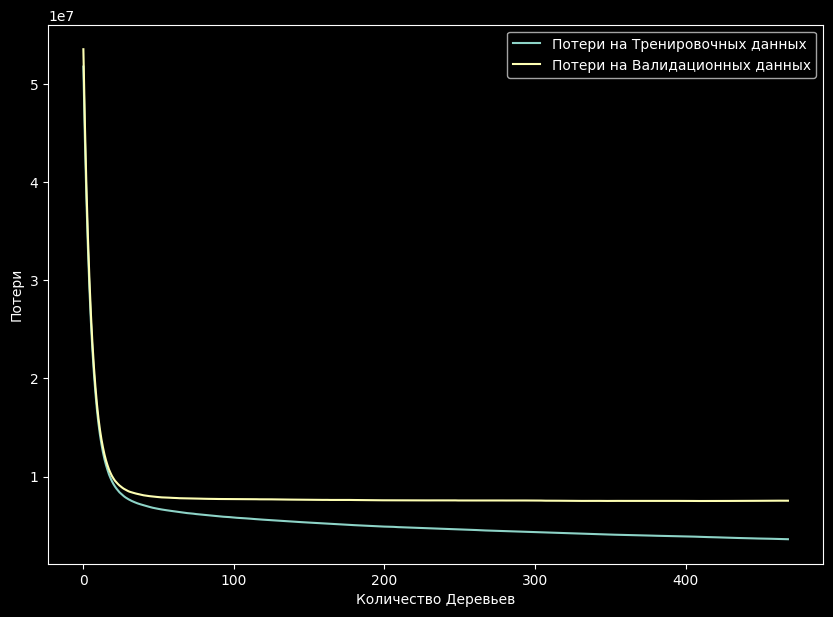

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(results["training"]["l2"], label="Потери на Тренировочных данных")
plt.plot(results["valid_1"]["l2"], label="Потери на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Потери")
plt.legend();

## Визуализация значимости признаков

In [ ]:
def feature_importance_plotter(model, features_names):
    """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
    Параметры:
    ===========
    model: модель
    features_names: список имен признаков
    """
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    #plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

Тут тоже по умолчанию не в диапазоне от 0 до 1

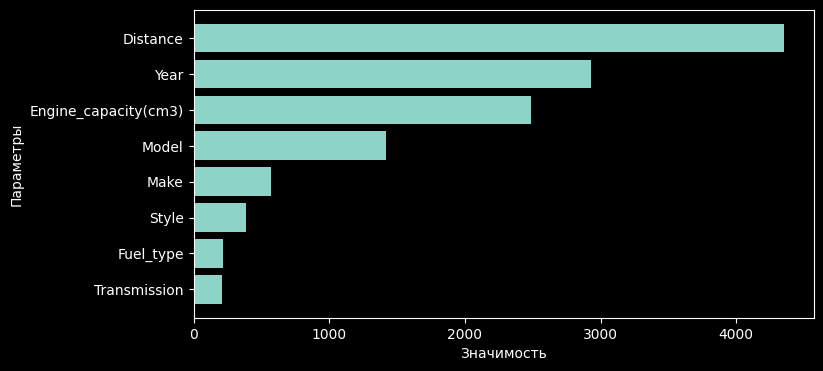

In [ ]:
feature_importance_plotter(model_reg, np.array(features_names))

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_reg, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_reg, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_reg, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_reg, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9373
r2 на валидационной выборке: 0.8809
mse на тренировочной выборке: 3814483.7613
mse на валидационной выборке: 7500483.0205


В нашем случае функцию для кросс-валидации нужно будет переписывать, поскольку `early_stopping_rounds` требует валидационного датасета, а `cross_validate` с такой задачей не справляется

## Визуализация ошибок от scikit-learn

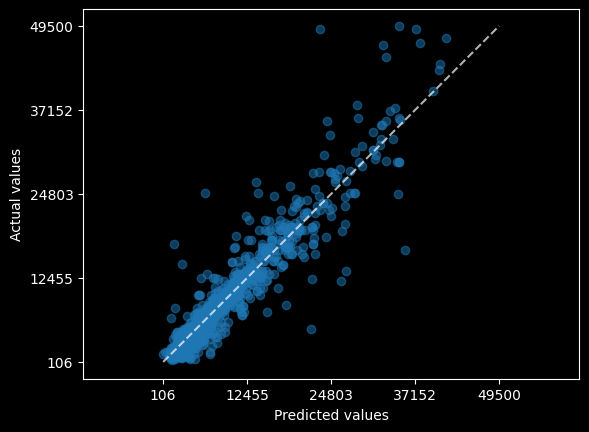

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_reg.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель регрессии от LightGBM ведет себя тоже уверенно

* В топе по значимости Трансмиссия, Год и Модель



# Сохранение / Загрузка

In [ ]:
# получаем экземпляр класса Booster
booster = model_reg.booster_

booster.save_model("lgb.mod")

In [ ]:
# Загрузка модели
loaded_booster = lgb.Booster(model_file="lgb.mod")


In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(loaded_booster, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(loaded_booster, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(loaded_booster, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(loaded_booster, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.9373
r2 на валидационной выборке: 0.8809
mse на тренировочной выборке: 3814483.7613
mse на валидационной выборке: 7500483.0205
